In [1]:
import sys
sys.path.append('../')
import dmg.model2graph.model2graph as m2g
import dmg.model2graph.metafilter as mf
from networkx.algorithms.isomorphism import is_isomorphic
import dmg.graphUtils as gu
import glob
import dmg.ecore.ecorePallete as ecore
import random
random.seed(123)

# Load dataset

In [2]:
metafilter_refs = ['EClass.eSuperTypes',
                          'EClassifier.ePackage',
                           'EPackage.eClassifiers',
                           'ETypedElement.eType',
                           'EStructuralFeature.eContainingClass',
                           'EReference.eOpposite',
                           'EEnum.eLiterals',
                           'EEnumLiteral.eEnum',
                           'EClass.eStructuralFeatures']
metafilter_cla = ['EClass', 'EPackage', 
                         'EStructuralFeature','EEnum', 'EEnumLiteral']   
metafilter_atts = None
metafilterobj = mf.MetaFilter(references = metafilter_refs, 
                 attributes = metafilter_atts,
                 classes = metafilter_cla)       
meta_models = []

In [5]:
files = glob.glob("../data/ecoreDataset/train/*")
graphs = []
for f in files:
    try:
        graphs.append(m2g.getGraphFromModel(f, 
                                  meta_models, metafilterobj,
                                  consider_atts = False))
    except:
        continue

In [6]:
print('Number of graphs:', len(graphs))

Number of graphs: 120


In [9]:
files = glob.glob("../data/ecoreDataset/val/*")
graphs_val = []
for f in files:
    try:
        graphs_val.append(m2g.getGraphFromModel(f, 
                                  meta_models, metafilterobj,
                                  consider_atts = False))
    except:
        continue

In [10]:
print('Number of graphs:', len(graphs_val))

Number of graphs: 30


In [13]:
from torch_geometric.data import DataLoader
from dmg.deeplearning.dataGeneration import sequence2data, data2graph
from dmg.deeplearning.dataGeneration import addInvEdges

listDatas_val = []
batch_size = 64
max_len = 2
print('Preparing seqs')
for g in graphs_val:
    sequence = ecore.ecore_pallete.graphToSequence(g)
    sequence = [(addInvEdges(s[0], ecore.ecore_pallete, ecore.ecore_separator),s[1]) for s in sequence]
    listDatas_val = listDatas_val + sequence2data(sequence, ecore.ecore_pallete, max_len)
loader_val = DataLoader(listDatas_val, batch_size=batch_size, 
                        num_workers = 0, 
                        shuffle=False)
print('Seqs finished')

Preparing seqs
Seqs finished


In [14]:
do_eval = False

if not do_eval:
    graphs = graphs + graphs_val

In [15]:
print('Number of graphs:', len(graphs))

Number of graphs: 150


# Training

In [17]:
from dmg.deeplearning.generativeModel import GenerativeModel
import torch
import torch.nn as nn
import multiprocess as mp

def f(g):
    sequence = ecore.ecore_pallete.graphToSequence(g)
    sequence = [(addInvEdges(s[0], ecore.ecore_pallete, ecore.ecore_separator),s[1]) for s in sequence]
    return sequence2data(sequence, ecore.ecore_pallete, max_len)

epochs = 100
hidden_dim = 128


criterion_node = nn.CrossEntropyLoss(reduction = 'mean',ignore_index=-1)
criterion_action = nn.CrossEntropyLoss(reduction = 'mean')
criterion_finish = nn.BCELoss(reduction = 'mean')
model = GenerativeModel(hidden_dim, ecore.dic_nodes_ecore, ecore.dic_edges_ecore, ecore.dic_operations_ecore)
opt = torch.optim.Adam(model.parameters(), lr=0.001)
#scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=10, gamma=0.1)

for epoch in range(epochs):
    model.train()
    total_loss = 0
    listDatas = []
    #preparing training set
    print('Preparing seqs')
    #for g in graphs:
    #    sequence = yp.yakindu_pallete.graphToSequence(g)
    #    listDatas = listDatas + sequence2data(sequence, yp.yakindu_pallete, max_len)
    with mp.Pool(10) as pool:
        listDatas = pool.map(f, graphs)
    listDatas = [r for rr in listDatas for r in rr]
    print('Seqs finished')
    loader = DataLoader(listDatas, batch_size=batch_size, 
                            num_workers = 0, 
                            shuffle=False)
    #training
    for data in loader:
        opt.zero_grad()
        action, nodes, finish = model(data.x, data.edge_index, 
                        torch.squeeze(data.edge_attr,dim=1), 
                data.batch, data.sequence, data.nodes, data.len_seq, data.action)
        
        nodes = torch.unsqueeze(nodes, dim = 2).repeat(1,1,2)
        nodes[:,:,0] = 1 - nodes[:,:,1]
            
        L = torch.max(data.len_seq).item()
        gTruth = data.sequence_masked[:,0:L]
        loss = (criterion_node(nodes.reshape(-1,2), gTruth.flatten()) +
                    criterion_action(action, data.action) +
                    criterion_finish(finish.flatten(), data.finished.float())) / 3
        total_loss += loss.item()
        loss.backward()
        opt.step()
    #validation
    if do_eval:
        val_loss = 0
        model.eval()
        with torch.no_grad():
            for data in loader_val:
                action, nodes, finish = model(data.x, data.edge_index, 
                            torch.squeeze(data.edge_attr,dim=1), 
                    data.batch, data.sequence, data.nodes, data.len_seq, data.action)
                nodes = torch.unsqueeze(nodes, dim = 2).repeat(1,1,2)
                nodes[:,:,0] = 1 - nodes[:,:,1]

                L = torch.max(data.len_seq).item()
                gTruth = data.sequence_masked[:,0:L]
                loss = (criterion_node(nodes.reshape(-1,2), gTruth.flatten()) +
                        criterion_action(action, data.action) +
                        criterion_finish(finish.flatten(), data.finished.float())) / 3
                val_loss+= loss.item()
        
    print('Epoch',epoch,'Loss Traning',total_loss/(len(loader)))
    #scheduler.step()
    if do_eval:
        print('Epoch',epoch,'Loss Val',val_loss/(len(loader_val)))
        

Preparing seqs
Seqs finished


/home/antolin/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 0 Loss Traning 0.6064978463976991
Preparing seqs
Seqs finished
Epoch 1 Loss Traning 0.526657784686369
Preparing seqs
Seqs finished
Epoch 2 Loss Traning 0.5252486157651041
Preparing seqs
Seqs finished
Epoch 3 Loss Traning 0.5133773649440092
Preparing seqs
Seqs finished
Epoch 4 Loss Traning 0.5071967121432809
Preparing seqs
Seqs finished
Epoch 5 Loss Traning 0.5019807961641574
Preparing seqs
Seqs finished
Epoch 6 Loss Traning 0.49880265371472227
Preparing seqs
Seqs finished
Epoch 7 Loss Traning 0.4944324557687722
Preparing seqs
Seqs finished
Epoch 8 Loss Traning 0.5002566272137212
Preparing seqs
Seqs finished
Epoch 9 Loss Traning 0.48816491049878735
Preparing seqs
Seqs finished
Epoch 10 Loss Traning 0.4923756882256153
Preparing seqs
Seqs finished
Epoch 11 Loss Traning 0.48760849295877945
Preparing seqs
Seqs finished
Epoch 12 Loss Traning 0.49053814422850517
Preparing seqs
Seqs finished
Epoch 13 Loss Traning 0.4867046826026019
Preparing seqs
Seqs finished
Epoch 14 Loss Traning 0.480

# Loading test

In [19]:
files = glob.glob("../data/ecoreDataset/test/*")
graphs_test = []
for f in files:
    try:
        graphs_test.append(m2g.getGraphFromModel(f, 
                                  meta_models, metafilterobj,
                                  consider_atts = False))
    except:
        continue
print('Number of graphs:', len(graphs_test))    

Number of graphs: 65


# Sample models

In [25]:
from dmg.deeplearning.generativeModel import sampleGraph

model.eval()
samples = [sampleGraph(ecore.G_initial_ecore_1, ecore.ecore_pallete, model, 100, ecore.ecore_separator) 
           for i in range(200)]

../dmg/deeplearning/generativeModel.py:131: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  m = Categorical(F.softmax(torch.squeeze(action)))
/home/antolin/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


# Visual comparison

## Size

/home/antolin/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/antolin/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


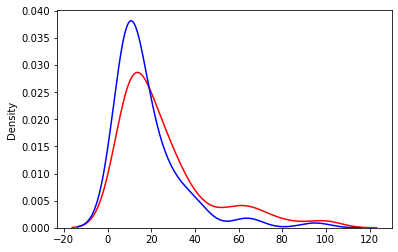

In [26]:
import seaborn as sns

sns.distplot([len(G) for G in samples], hist=False, kde=True, 
             bins=int(180/5), color = 'red', label = 'NN')
sns.distplot([len(G) for G in graphs_test], hist=False, kde=True, 
             bins=int(180/5), color = 'blue', label = 'Real')

## Degree

/home/antolin/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/antolin/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


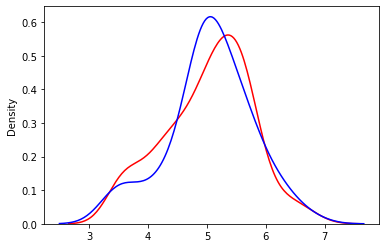

In [27]:
import numpy as np
import dmg.realism.metrics as mt
sns.distplot([np.mean(mt.getListDegree(G)) for G in samples], hist=False, kde=True, 
             bins=int(180/5), color = 'red', label = 'NN')
sns.distplot([np.mean(mt.getListDegree(G)) for G in graphs_test], hist=False, kde=True, 
             bins=int(180/5), color = 'blue', label = 'Real')

## MPC

/home/antolin/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/antolin/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


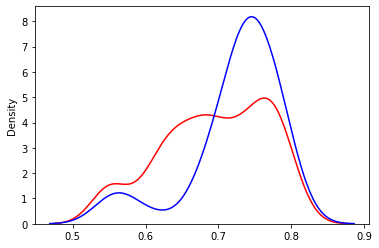

In [28]:
dims = list(ecore.dic_edges_ecore.keys())
sns.distplot([np.mean(list(mt.MPC(G,dims).values())) for G in samples], hist=False, kde=True, 
             bins=int(180/5), color = 'red', label = 'NN')
sns.distplot([np.mean(list(mt.MPC(G,dims).values())) for G in graphs_test], hist=False, kde=True, 
             bins=int(180/5), color = 'blue', label = 'Real')

# Check isomorf and consistency

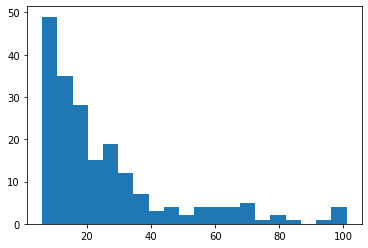

In [29]:
import matplotlib.pyplot as plt

h = plt.hist([len(G) for G in samples], bins = 20)

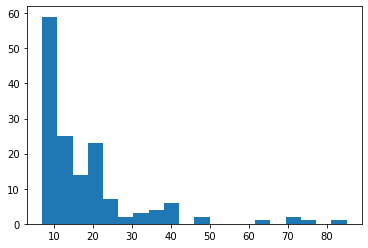

In [30]:
h = plt.hist([len(G) for G in graphs], bins = 20)

In [31]:
#check isomorf
iso = []
for s in samples:
    for g in graphs:
        if (is_isomorphic(s,g,gu.node_match_type, gu.edge_match_type)):
            iso.append(s)
            break
print(len(iso)*100/len(samples),'% iso')
not_iso = [g for g in samples if not g in iso]

7.5 % iso


Mean size: 8.6


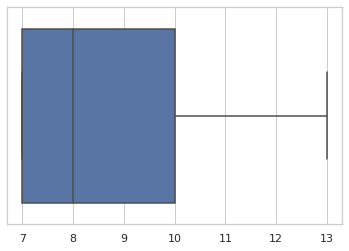

In [32]:
import numpy as np
import seaborn as sns

sns.set_theme(style="whitegrid")
ax = sns.boxplot(x=[len(G) for G in iso])
print('Mean size:', np.mean([len(G) for G in iso]))

In [ ]:
from dmg.yakindu.yakinduConsistency import inconsistent
#check consistency
inconsistents = []
for s in samples:
    if inconsistent(s):
        inconsistents.append(s)
print(len(inconsistents)*100/len(samples),'% inconsistents')
not_inconsistents = [g for g in samples if not g in inconsistents]

In [ ]:
ax = sns.boxplot(x=[len(G) for G in inconsistents])
print('Mean size:', np.mean([len(G) for G in inconsistents]))

In [ ]:
clean_new_models = [g for g in not_iso if not g in inconsistents]

In [ ]:
ax = sns.boxplot(x=[len(G) for G in clean_new_models])
print('Mean size:', np.mean([len(G) for G in clean_new_models]))

In [ ]:
ax = sns.boxplot(x=[len(G) for G in graphs])
print('Mean size:', np.mean([len(G) for G in graphs]))

In [ ]:
print(len(clean_new_models),'clean models')
print(len(clean_new_models)*100/len(samples),'% clean models')

# Clean models

In [ ]:
import seaborn as sns

sns.distplot([len(G) for G in clean_new_models], hist=False, kde=True, 
             bins=int(180/5), color = 'red', label = 'NN')
sns.distplot([len(G) for G in graphs_test], hist=False, kde=True, 
             bins=int(180/5), color = 'blue', label = 'Real')

In [ ]:
sns.distplot([np.mean(mt.getListDegree(G)) for G in clean_new_models], hist=False, kde=True, 
             bins=int(180/5), color = 'red', label = 'NN')
sns.distplot([np.mean(mt.getListDegree(G)) for G in graphs_test], hist=False, kde=True, 
             bins=int(180/5), color = 'blue', label = 'Real')

In [ ]:
dims = list(yp.dic_edges_yak.keys())
sns.distplot([np.mean(list(mt.MPC(G,dims).values())) for G in clean_new_models], hist=False, kde=True, 
             bins=int(180/5), color = 'red', label = 'NN')
sns.distplot([np.mean(list(mt.MPC(G,dims).values())) for G in graphs_test], hist=False, kde=True, 
             bins=int(180/5), color = 'blue', label = 'Real')

# Consistent models

In [ ]:
import seaborn as sns

sns.distplot([len(G) for G in not_inconsistents], hist=False, kde=True, 
             bins=int(180/5), color = 'red', label = 'NN')
sns.distplot([len(G) for G in graphs_test], hist=False, kde=True, 
             bins=int(180/5), color = 'blue', label = 'Real')

In [ ]:
sns.distplot([np.mean(mt.getListDegree(G)) for G in not_inconsistents], hist=False, kde=True, 
             bins=int(180/5), color = 'red', label = 'NN')
sns.distplot([np.mean(mt.getListDegree(G)) for G in graphs_test], hist=False, kde=True, 
             bins=int(180/5), color = 'blue', label = 'Real')

In [ ]:
dims = list(yp.dic_edges_yak.keys())
sns.distplot([np.mean(list(mt.MPC(G,dims).values())) for G in not_inconsistents], hist=False, kde=True, 
             bins=int(180/5), color = 'red', label = 'NN')
sns.distplot([np.mean(list(mt.MPC(G,dims).values())) for G in graphs_test], hist=False, kde=True, 
             bins=int(180/5), color = 'blue', label = 'Real')

# Realism using GNN

In [ ]:
from torch_geometric.data import Data
from dmg.deeplearning.dataGeneration import generateTensorsFromGraph
syns = []
sett = clean_new_models
for G in random.sample(sett,min(len(sett),len(graphs_test))):
    G_inv = addInvEdges(G, yp.yakindu_pallete, yp.yakindu_separator)
    tensors = generateTensorsFromGraph(G_inv, yp.yakindu_pallete, 2, 2)
    data =  Data(x = tensors[0],
                edge_index = tensors[-2], 
                edge_attr = tensors[-1],
                y = torch.tensor(0))
    syns.append(data)

In [ ]:
reals = []
for G in random.sample(graphs_test,min(len(sett),len(graphs_test))):
    G_inv = addInvEdges(G, yp.yakindu_pallete, yp.yakindu_separator)
    tensors = generateTensorsFromGraph(G_inv, yp.yakindu_pallete, 2, 2)
    data =  Data(x = tensors[0],
                edge_index = tensors[-2], 
                edge_attr = tensors[-1],
                y = torch.tensor(1))
    reals.append(data)

In [ ]:
dataset = syns + reals
random.shuffle(dataset)
print('Len train:', len(dataset))

In [ ]:
from torch.utils.data import random_split
import torch
train_len = int(0.8*len(dataset))
test_len = len(dataset) - int(0.8*len(dataset))
train, test = random_split(dataset, [train_len, test_len], 
                                generator=torch.Generator().manual_seed(42))

In [ ]:
train_loader = DataLoader(train, batch_size=32, num_workers = 5, shuffle=True)
test_loader = DataLoader(test, batch_size=1, num_workers = 5, shuffle=True)

In [ ]:
import torch.nn as nn
from dmg.realism.discriminativeModel import DiscriminativeModel

model = DiscriminativeModel(64,64,0.0,yp.dic_nodes_yak,yp.dic_edges_yak).cpu()

epochs = 100
criterion = nn.BCELoss()

opt = torch.optim.Adam(model.parameters(), lr=0.001)


for e in range(epochs):
    total_loss = 0.0
    b = 1
    model.train()
    for data in train_loader:
        
        opt.zero_grad()
        
        pred = model(data.x.cpu(), data.edge_index.cpu(),
          torch.squeeze(data.edge_attr.cpu(),dim=1),data.batch.cpu())
        
        loss = criterion(torch.squeeze(pred), data.y.float().cpu())
        total_loss += loss.item()
        
        loss.backward()
        opt.step()
        b = b + 1
        
    print('Epoch',e,'Loss',total_loss/b)


In [ ]:
model.eval()
count = 0
i0 = 0
i1 = 0
for data in test_loader:
    pred = model(data.x.cpu(), data.edge_index.cpu(),
          torch.squeeze(data.edge_attr,dim=1).cpu(),data.batch.cpu())
    if pred[0].item() > 0.5:
        pred = 1
    else:
        pred = 0
    if pred == data.y.long().item():
        count = count + 1
    
print('Acc', count/len(test_loader))

In [ ]:
import scipy.stats as st
import math

def C2ST_pvalue(acc,n_test):
    return st.norm.cdf(-(acc-0.5)/(math.sqrt(1/(4*n_test))))

print('p-value', C2ST_pvalue(count/len(test_loader),len(test_loader)))

# Plot a sample of clean models

In [ ]:
dot = gu.plotGraphViz(random.sample(clean_new_models,1)[0])
dot.format = 'pdf'
dot.view(filename='example', directory='./')

In [ ]:
#m2g.getModelFromGraph(['../data/metamodels/yakinduSimplified.ecore'], clean_new_models[0])

In [ ]:
m2g.serializeGraphModel('example.xmi',['../data/metamodels/yakinduSimplified.ecore'], 'Statechart', clean_new_models[0])